In [1]:
"""Experiment with parsun shade multilayer."""
# %%
import os
from dataclasses import asdict
from math import isclose

from numpy.lib.function_base import average
from pyDO3SE.util.Objects import Field
from pyDO3SE.Analysis.charts import multi_series_annual_graph

import pytest
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d  # noqa: F401

from pyDO3SE.constants.physical_constants import DRATIO_H20_O3
from pyDO3SE.plugins.met.irradiance import (
    calc_Idrctt_Idfuse,
    calc_PAR_sun_shade,
    calc_is_daylight,
)
from pyDO3SE.plugins.met.solar_position import calc_solar_elevation
from pyDO3SE.plugins.met.wind import calc_windspeed_parameters

from pyDO3SE.plugins.met.thermal_time import calc_thermal_time
# from pyDO3SE.plugins.gsto.photosynthesis_helpers import calc_g_bv
# from pyDO3SE.plugins.met.thermal_time import get_td_dd

# from pyDO3SE.plugins.O3.helpers import O3_ppb_to_nmol


In [2]:

# SAVE_OUTPUTS_LOCATION = './notebooks/multilayered_approach/output/'
DEMO_DATA_LOCATION = './examples/spanish_wheat/spanish_wheat_data_test.csv'

t_lem_constant = 0.15
t_lse_constant = 0.33


In [3]:


# import data
df = pd.read_csv(DEMO_DATA_LOCATION)
data = {}
data["Ts_C"] = df['Ts_C'].values.reshape((365, 24))
data["u"] = df['u'].values.reshape((365, 24))
data["VPD"] = df['VPD'].values.reshape((365, 24))
data["PAR"] = df['PAR, W m-2'].values.reshape((365, 24))
data["P"] = df['P, kPa'].values.reshape((365, 24))
data['Lai'] = df['LAI'].values.reshape((365, 24))
td_data = np.array(calc_thermal_time(df['Ts_C'].values))

# previous_day_output = None
output_data = []
input_data = []
D_0 = 2.27
day_count = 365
fO3_d_prev = 1
O3up_prev = 0.0
O3up_acc = 0.0
td_dd_prev = 0.0


In [4]:


def get_sun_shade_values(nL: int, cosA: float = 0.5):

    PARSunShade_values = []
    LAI_c_values = []

    for dd in range(day_count):
        # if dd != 50: continue
        # fo3_d_acc = 0
        td = td_data[dd]

        for hr in range(24):
            LAI = [2 / nL for i in range(nL)]
            # LAI = [10 * data["Lai"][dd][hr] / nL for i in range(nL)]
            LAI_c = [sum(LAI[0:i]) for i in range(nL)]
            # print(f'LAI: {LAI} LAI_c {LAI_c}')
            sinB = calc_solar_elevation(40.43, -3.7, dd, hr)
            PAR = data["PAR"][dd][hr]
            P = data["P"][dd][hr]
            Idrctt, Idfuse, _ = calc_Idrctt_Idfuse(PAR, sinB, P)
            PARSunShade = [calc_PAR_sun_shade(Idrctt, Idfuse, sinB, cosA, lai_c) for lai_c in LAI_c]
            is_daylight = calc_is_daylight(PAR)
            PARSunShade_values.append(PARSunShade)
            LAI_c_values.append(LAI_c)

    sun_vals = [[p[i].PARsun for p in PARSunShade_values] for i in range(nL)]
    shade_vals = [[p[i].PARshade for p in PARSunShade_values] for i in range(nL)]
    return sun_vals, shade_vals



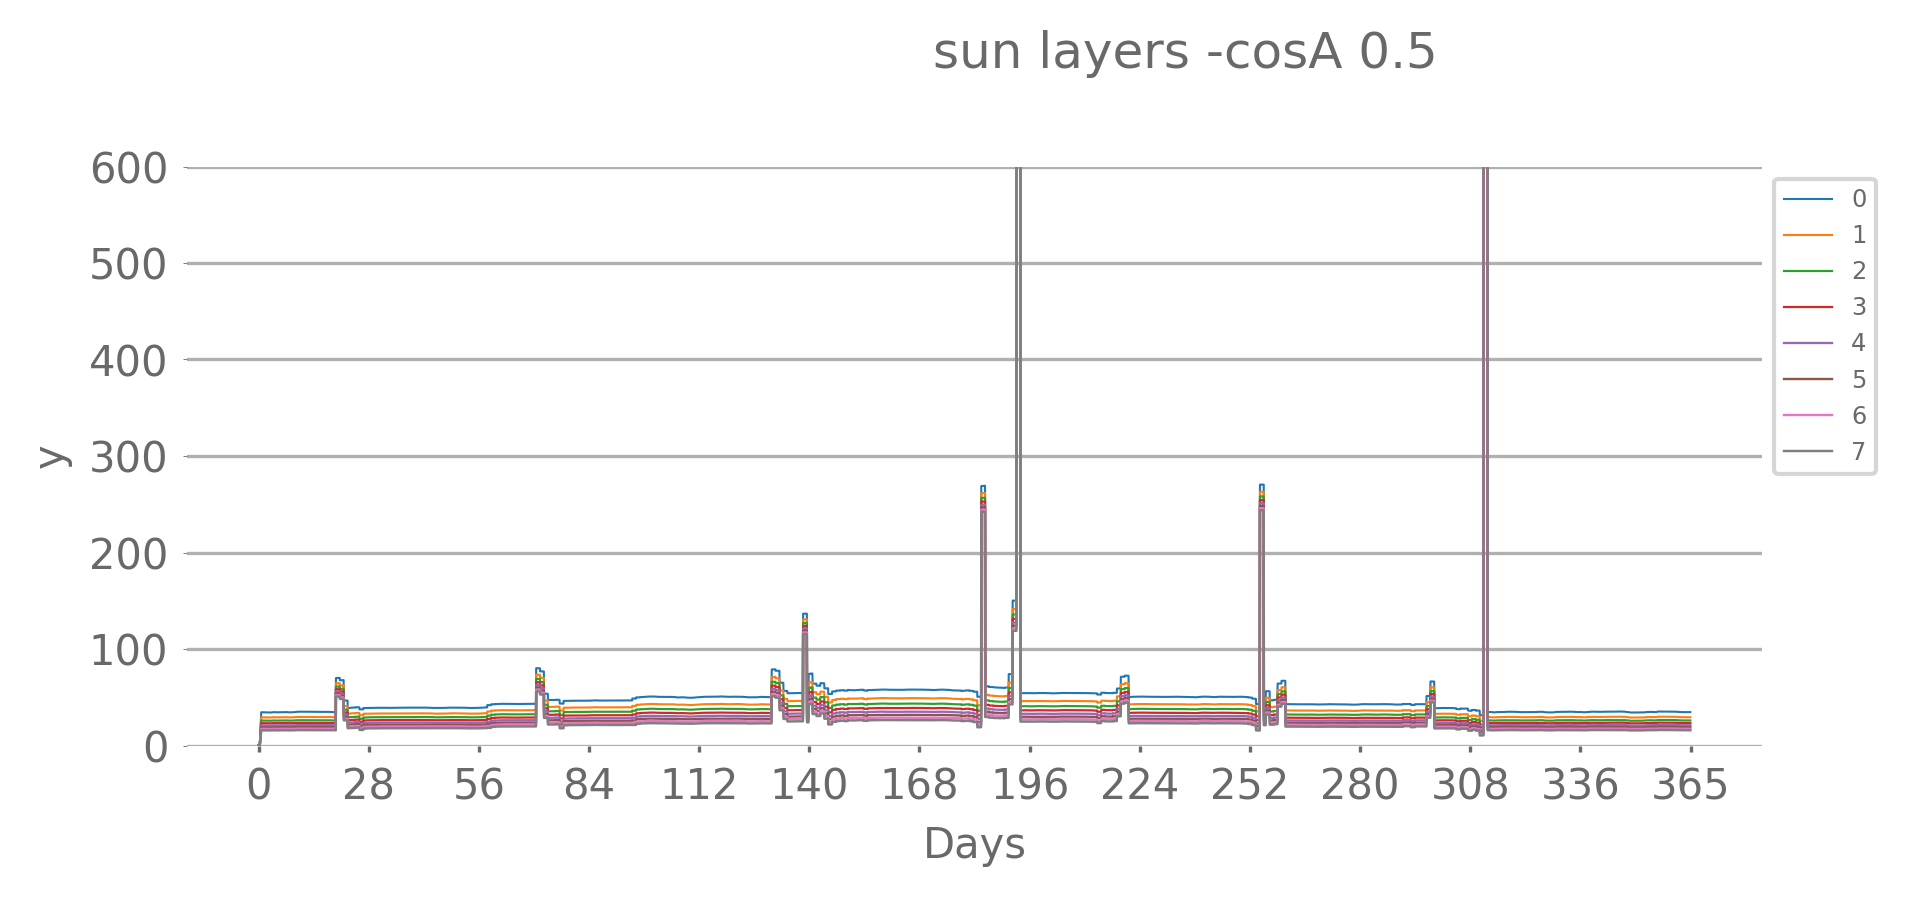

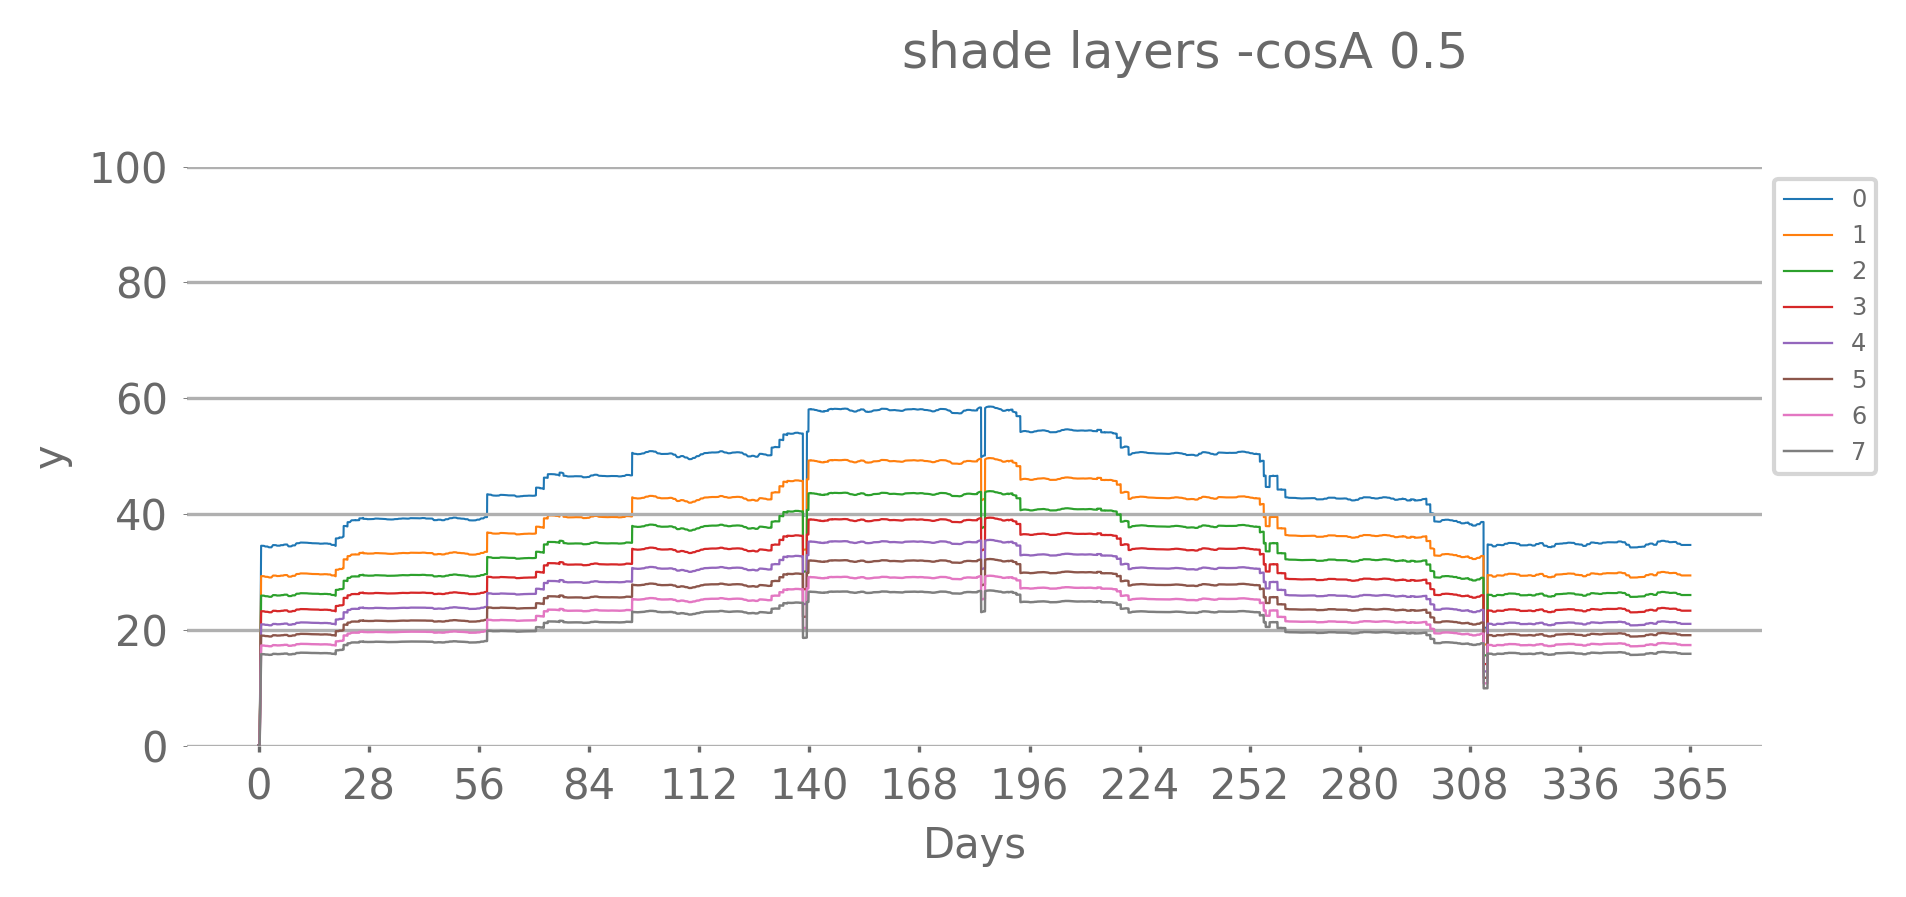

In [5]:
nL = 8
sun_vals, shade_vals = get_sun_shade_values(nL)
fig = multi_series_annual_graph(
    'sun layers -cosA 0.5',
    sun_vals,
    [i for i in range(nL)],
    None,
    label_x_days=30,
    average_step=24,
    top_y_lim=600,
    figsize=(8, 3),
    dpi=300,
)
fig.show()
fig = multi_series_annual_graph(
    'shade layers -cosA 0.5',
    shade_vals,
    [i for i in range(nL)],
    None,
    label_x_days=30,
    average_step=24,
    top_y_lim=100,
    figsize=(8, 3),
    dpi=300,
)
fig.show()


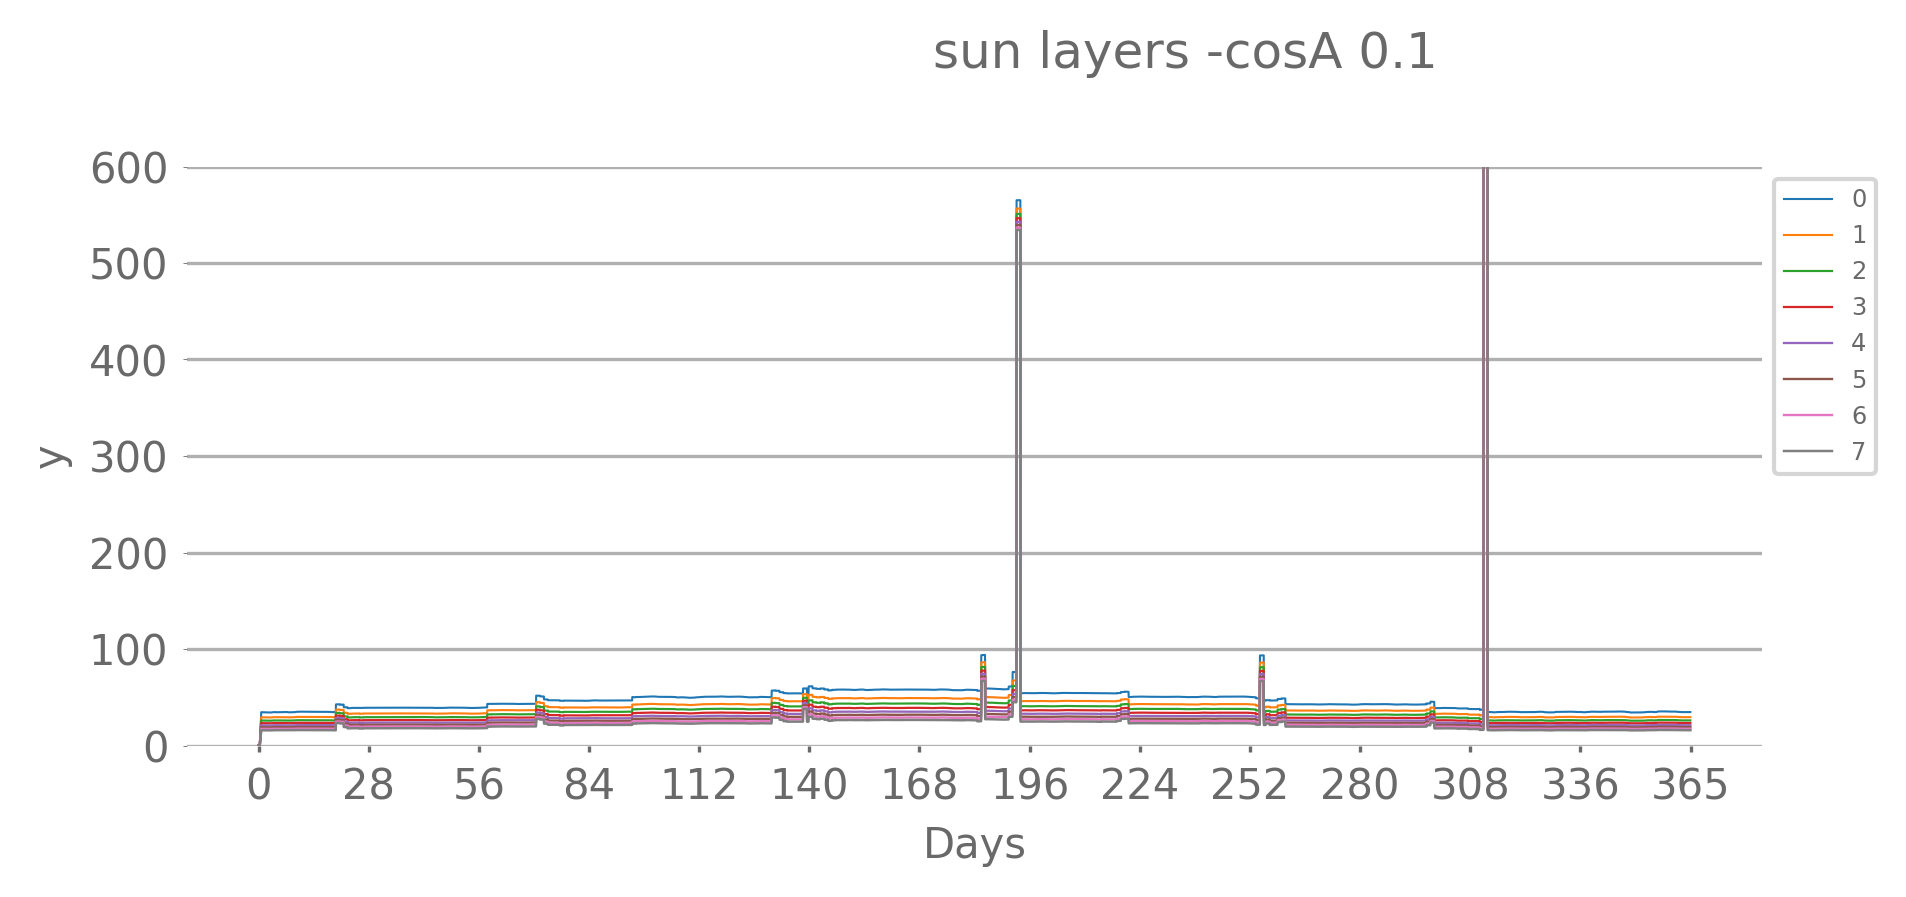

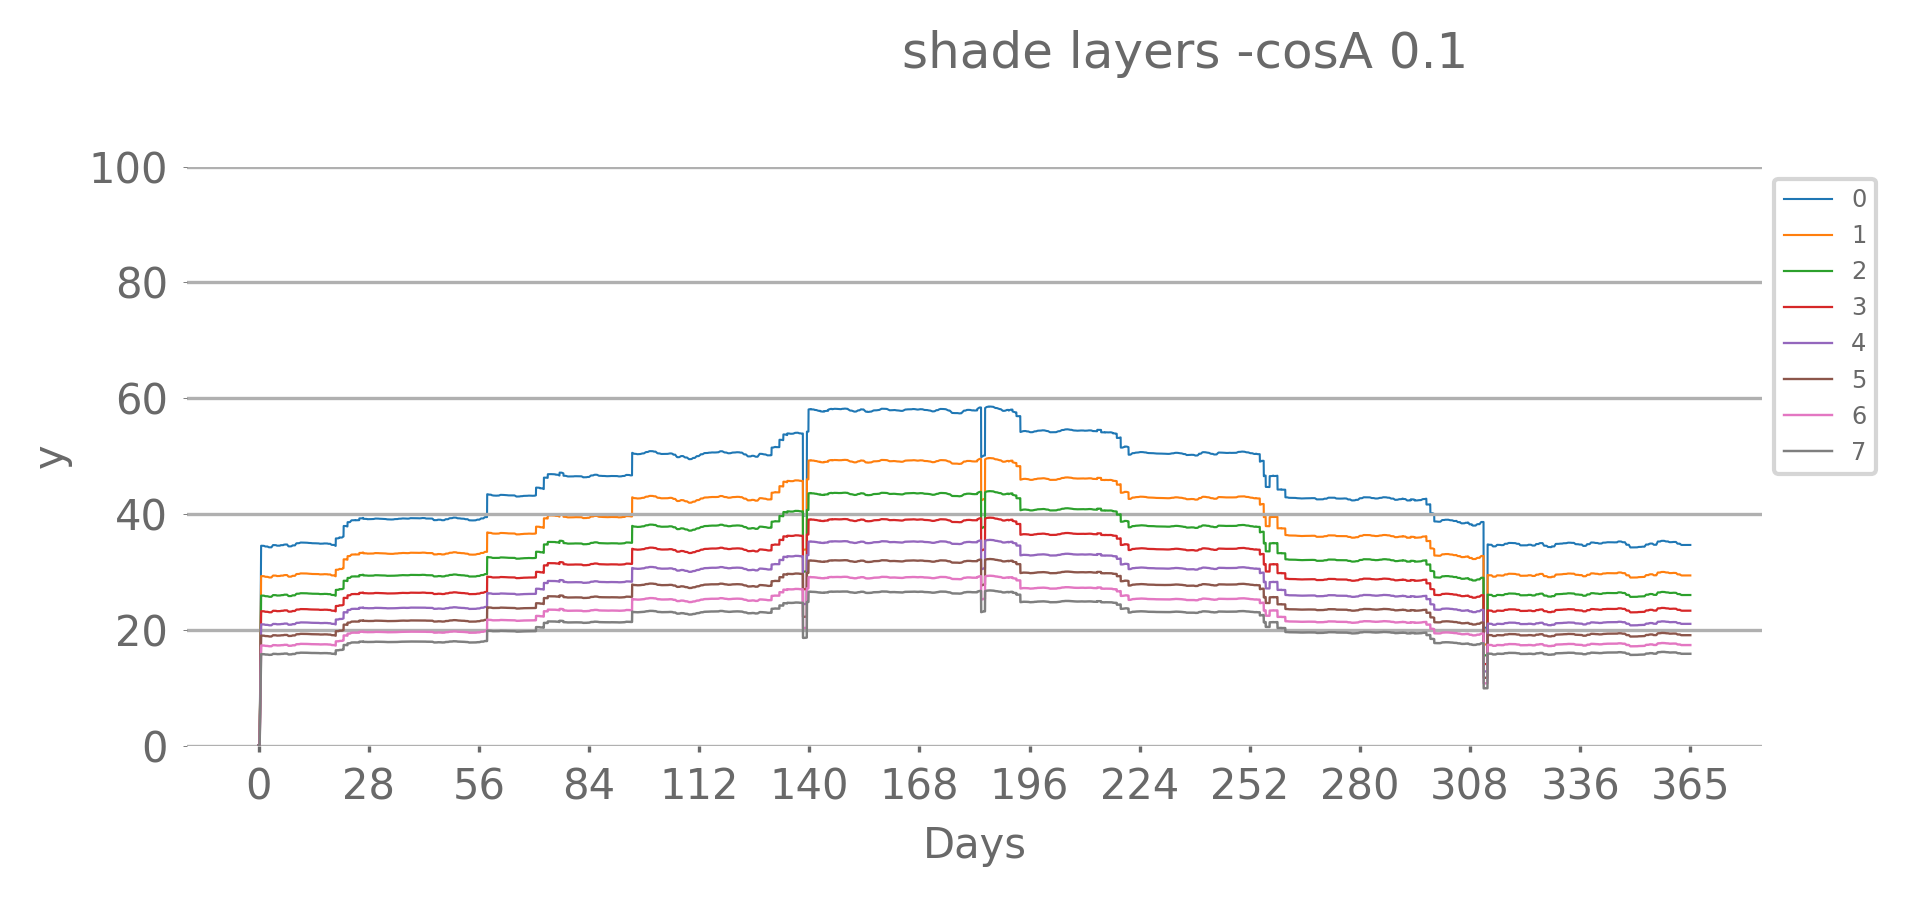

In [6]:
nL = 8
sun_vals, shade_vals = get_sun_shade_values(nL, cosA=0.1)
fig = multi_series_annual_graph(
    'sun layers -cosA 0.1',
    sun_vals,
    [i for i in range(nL)],
    None,
    label_x_days=30,
    average_step=24,
    top_y_lim=600,
    figsize=(8, 3),
    dpi=300,
)
fig.show()
fig = multi_series_annual_graph(
    'shade layers -cosA 0.1',
    shade_vals,
    [i for i in range(nL)],
    None,
    label_x_days=30,
    average_step=24,
    top_y_lim=100,
    figsize=(8, 3),
    dpi=300,
)
fig.show()

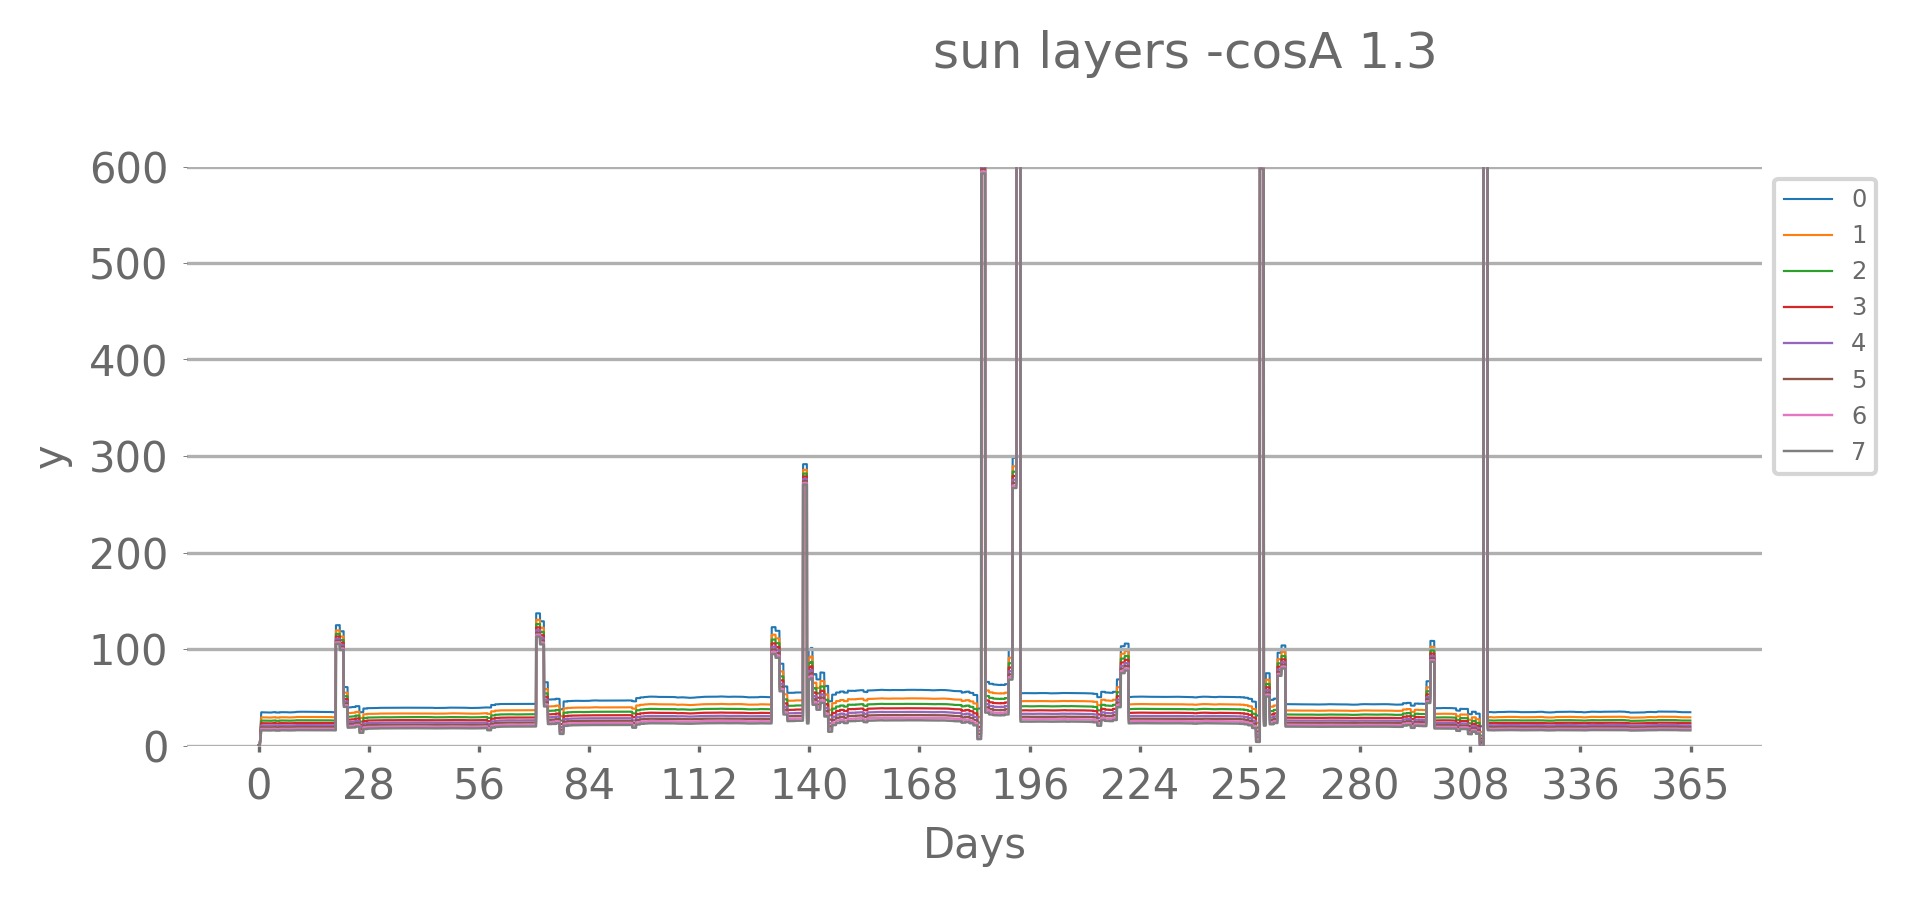

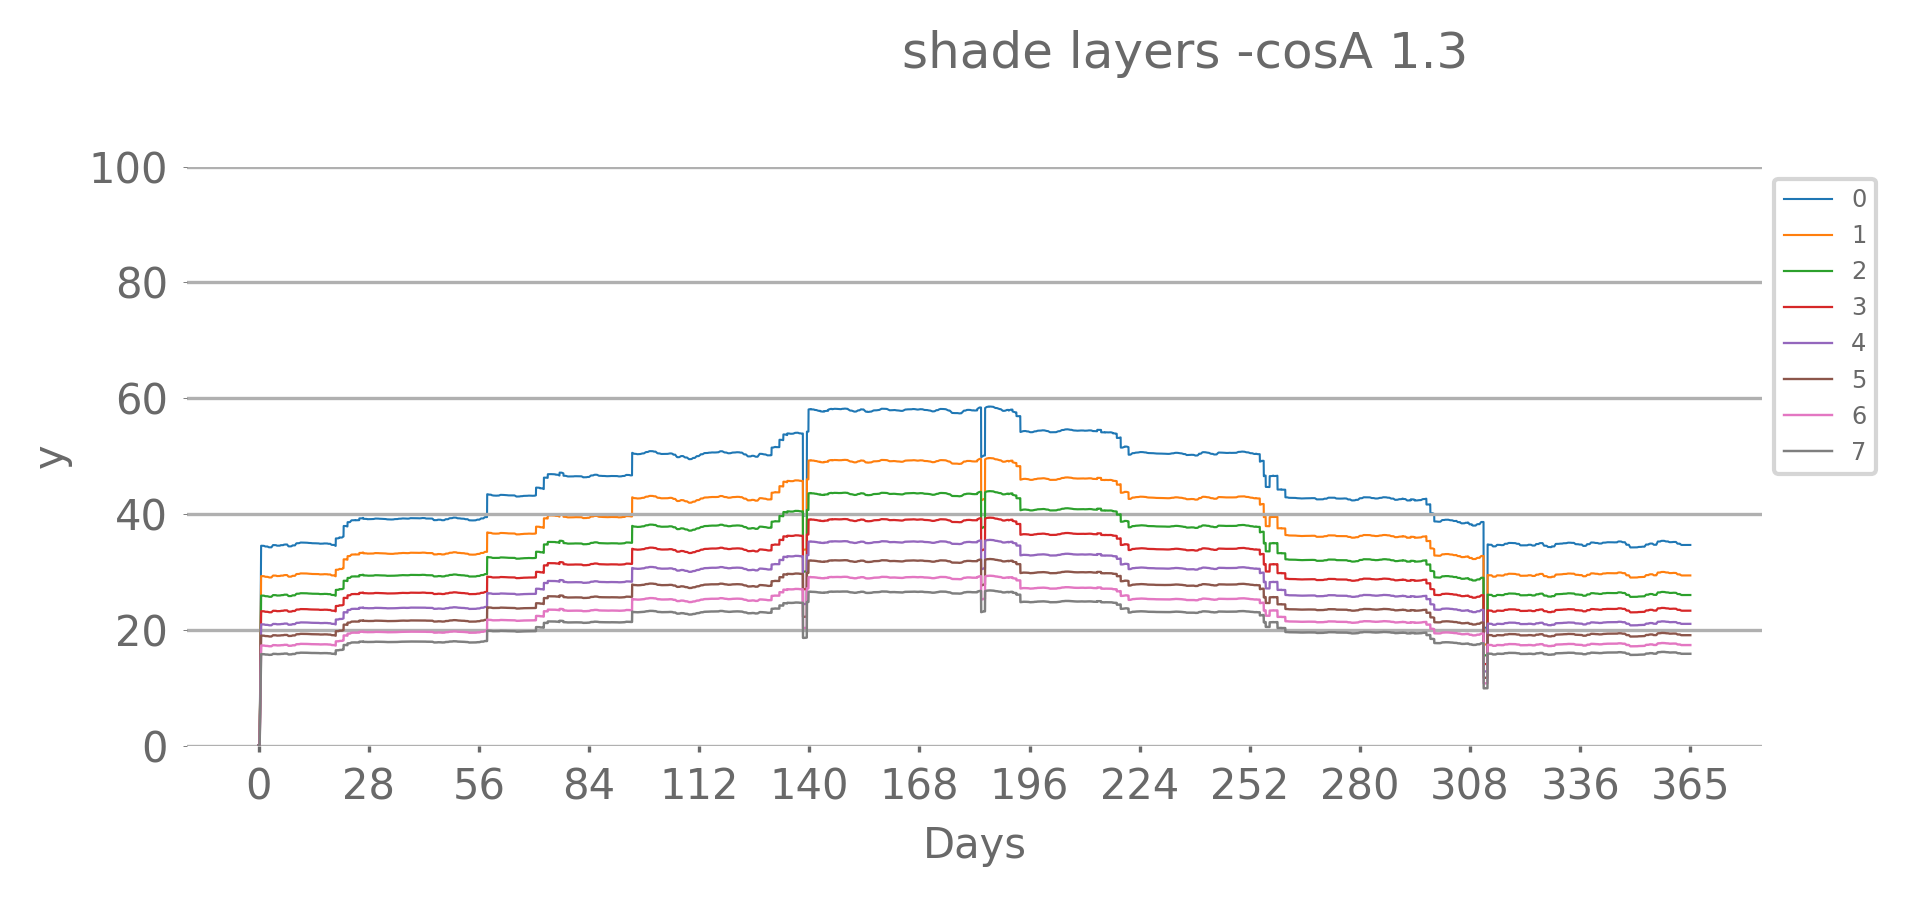

In [7]:
nL = 8
sun_vals, shade_vals = get_sun_shade_values(nL, cosA=1.3)
fig = multi_series_annual_graph(
    'sun layers -cosA 1.3',
    sun_vals,
    [i for i in range(nL)],
    None,
    label_x_days=30,
    average_step=24,
    top_y_lim=600,
    figsize=(8, 3),
    dpi=300,
)
fig.show()
fig = multi_series_annual_graph(
    'shade layers -cosA 1.3',
    shade_vals,
    [i for i in range(nL)],
    None,
    label_x_days=30,
    average_step=24,
    top_y_lim=100,
    figsize=(8, 3),
    dpi=300,
)
fig.show()

In [8]:

# ============= Show for a single day =============== #


def get_sun_shade_values_day(nL: int, cosA: float = 0.5):

    PARSunShade_values = []
    LAI_c_values = []
    dd = 150
    # if dd != 50: continue
    # fo3_d_acc = 0
    td = td_data[dd]

    for hr in range(24):
        LAI = [2 / nL for i in range(nL)]
        # LAI = [10 * data["Lai"][dd][hr] / nL for i in range(nL)]
        LAI_c = [sum(LAI[0:i]) for i in range(nL)]
        # print(f'LAI: {LAI} LAI_c {LAI_c}')
        sinB = calc_solar_elevation(40.43, -3.7, dd, hr)
        PAR = data["PAR"][dd][hr]
        P = data["P"][dd][hr]
        Idrctt, Idfuse, _ = calc_Idrctt_Idfuse(PAR, sinB, P)
        PARSunShade = [calc_PAR_sun_shade(Idrctt, Idfuse, sinB, cosA, lai_c) for lai_c in LAI_c]
        is_daylight = calc_is_daylight(PAR)
        PARSunShade_values.append(PARSunShade)
        LAI_c_values.append(LAI_c)

    sun_vals = [[p[i].PARsun for p in PARSunShade_values] for i in range(nL)]
    shade_vals = [[p[i].PARshade for p in PARSunShade_values] for i in range(nL)]
    return sun_vals, shade_vals



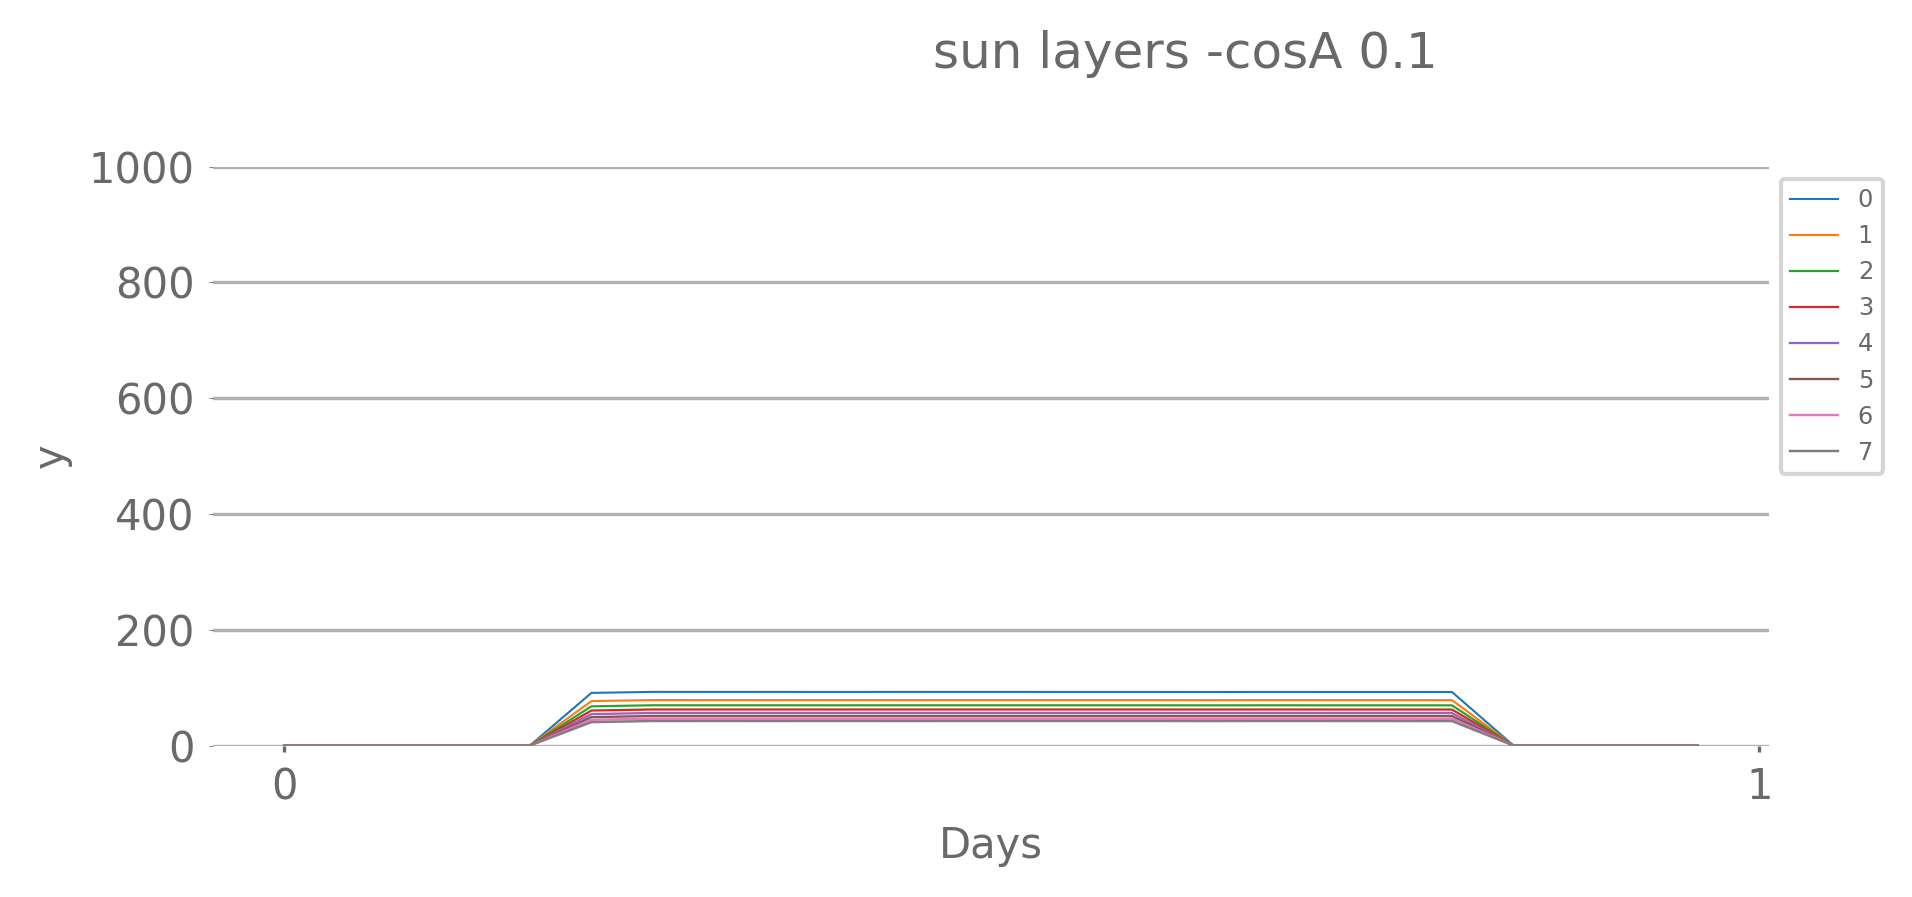

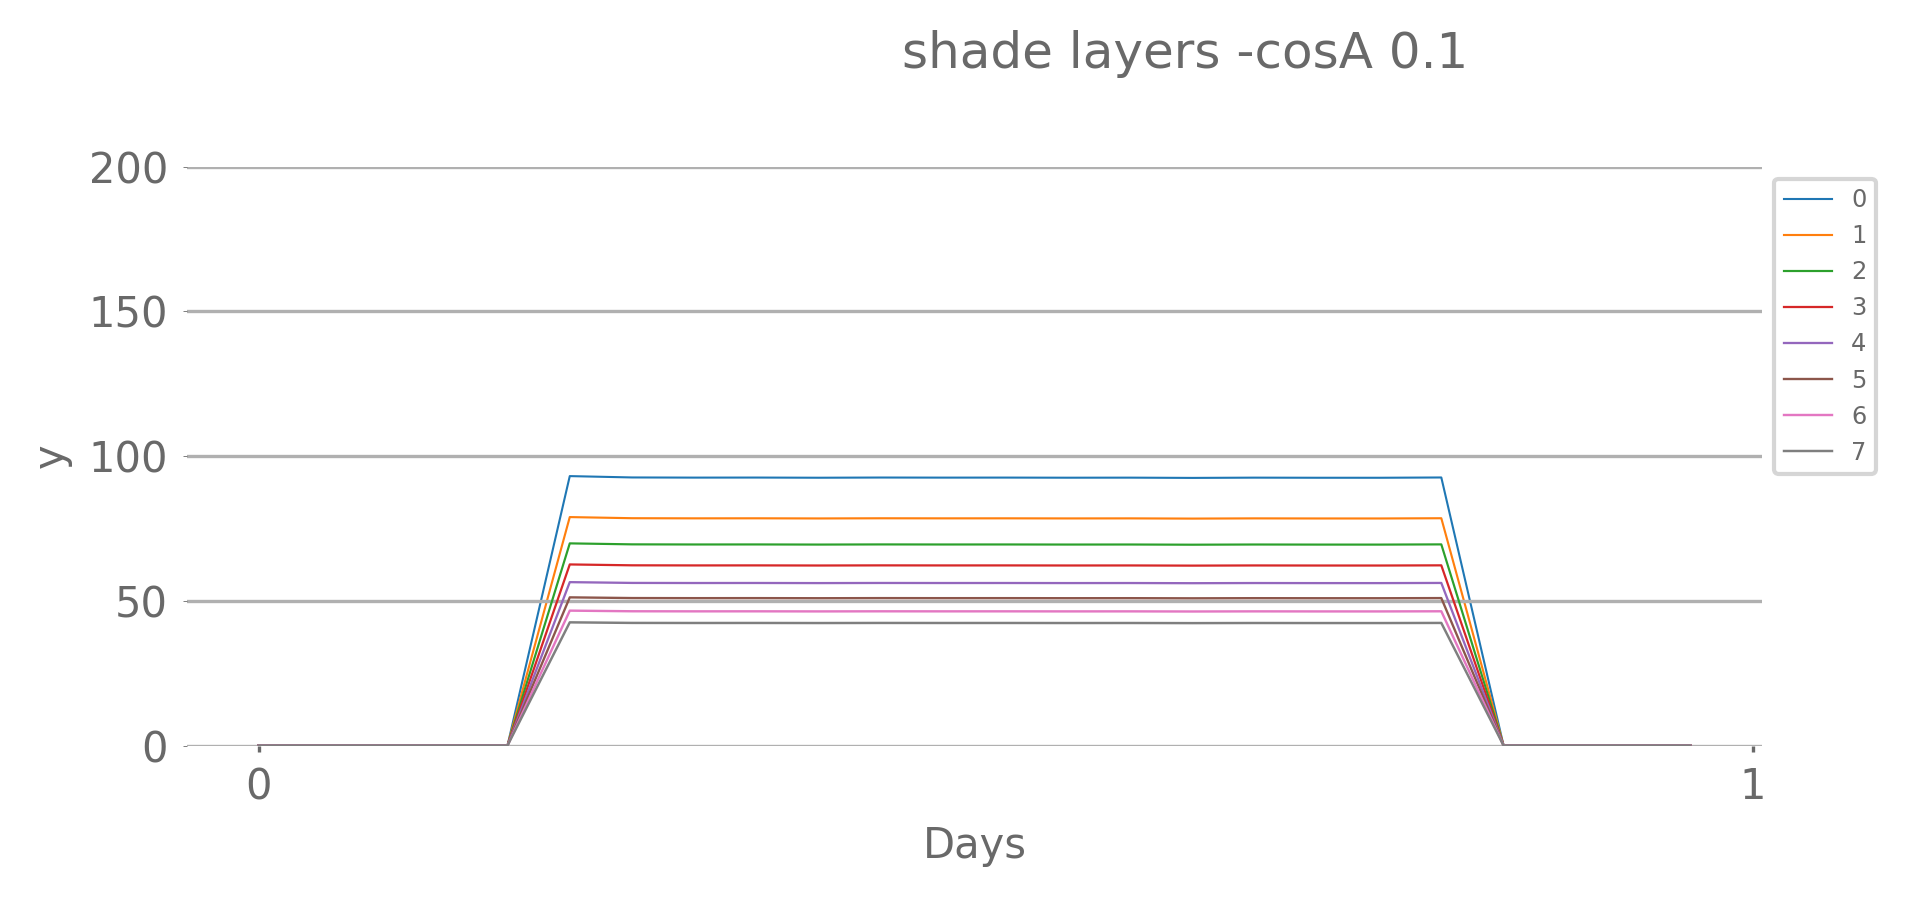

In [9]:
nL = 8
sun_vals, shade_vals = get_sun_shade_values_day(nL, cosA=0.1)
fig = multi_series_annual_graph(
    'sun layers -cosA 0.1',
    sun_vals,
    [i for i in range(nL)],
    None,
    label_x_days=30,
    average_step=1,
    end_day=1,
    top_y_lim=1000,
    figsize=(8, 3),
    dpi=300,
)
fig.show()
fig = multi_series_annual_graph(
    'shade layers -cosA 0.1',
    shade_vals,
    [i for i in range(nL)],
    None,
    label_x_days=30,
    average_step=1,
    end_day=1,
    top_y_lim=200,
    figsize=(8, 3),
    dpi=300,
)
fig.show()



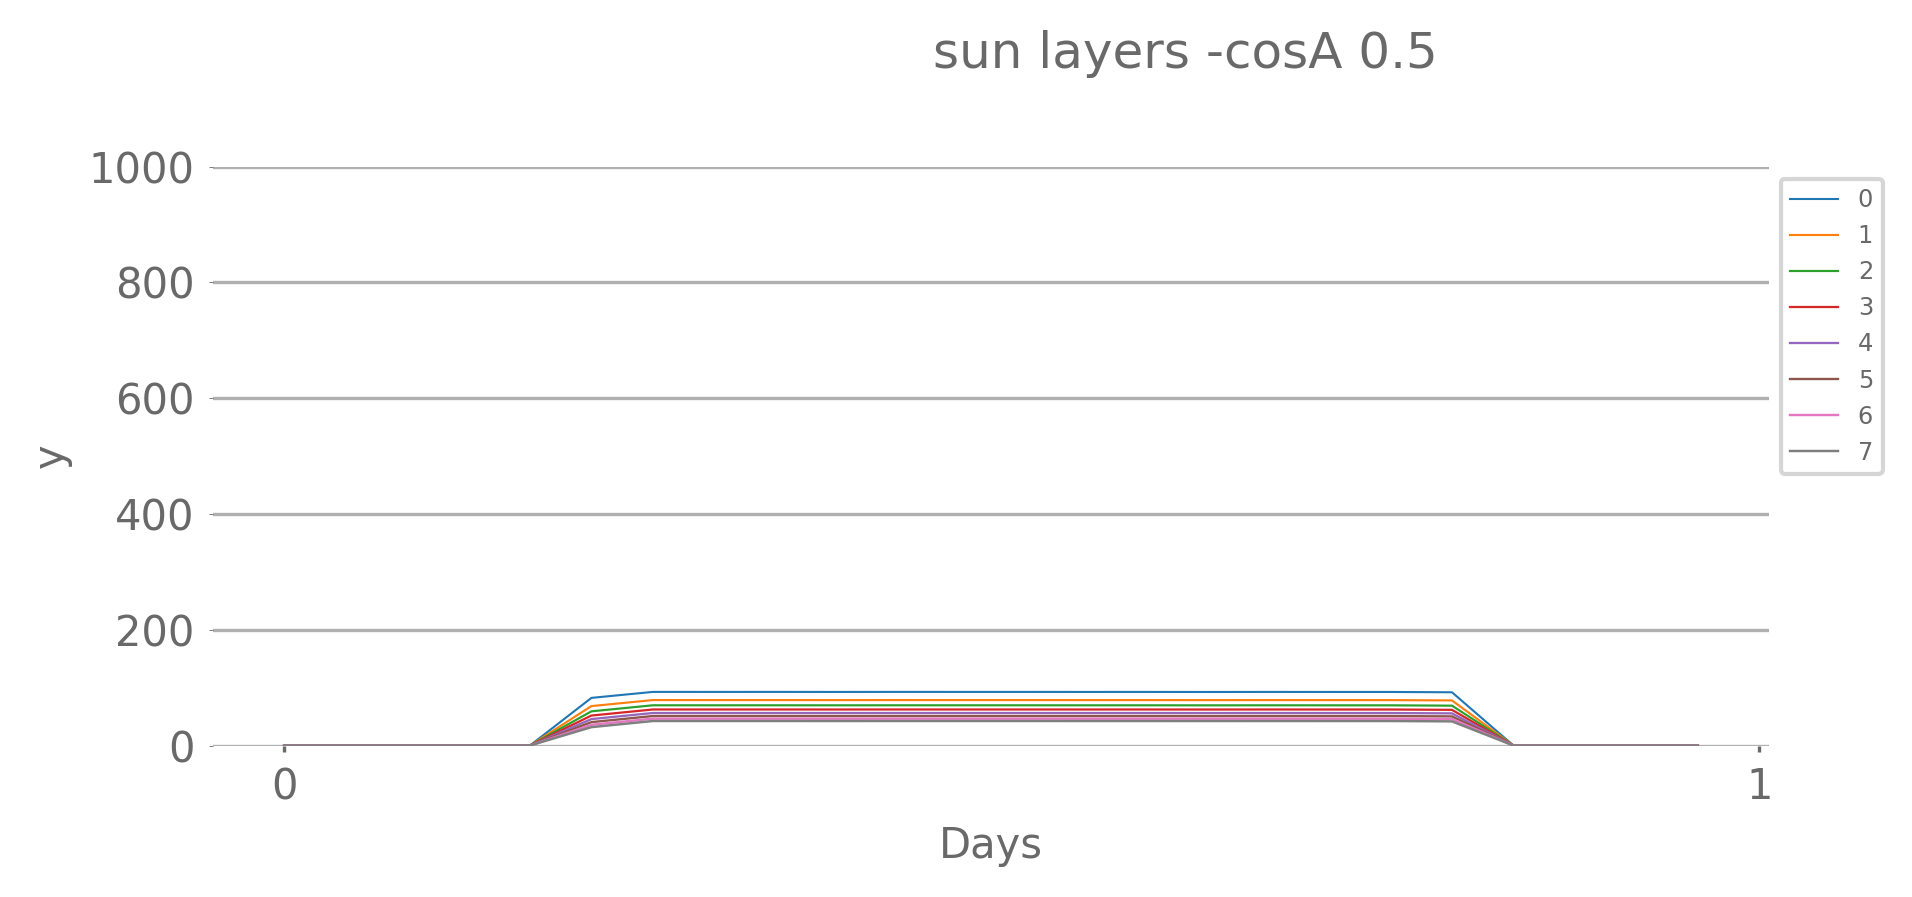

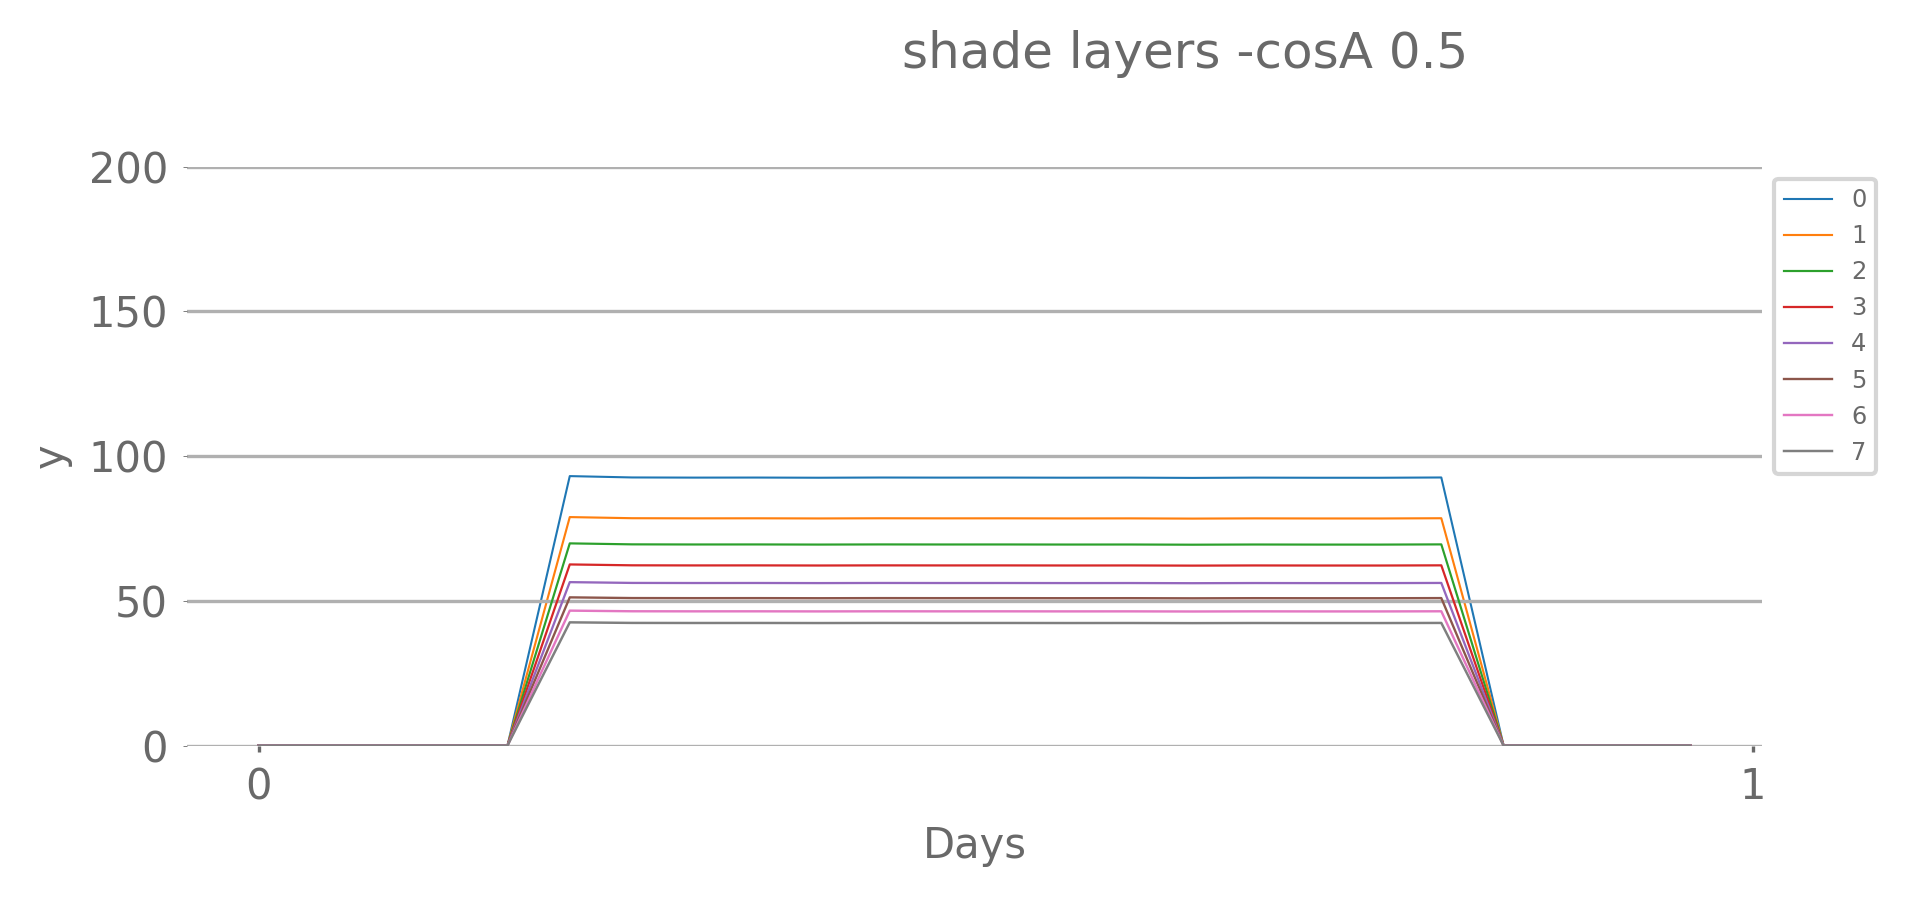

In [10]:
nL = 8
sun_vals, shade_vals = get_sun_shade_values_day(nL, cosA=0.5)
fig = multi_series_annual_graph(
    'sun layers -cosA 0.5',
    sun_vals,
    [i for i in range(nL)],
    None,
    label_x_days=30,
    average_step=1,
    end_day=1,
    top_y_lim=1000,
    figsize=(8, 3),
    dpi=300,
)
fig.show()
fig = multi_series_annual_graph(
    'shade layers -cosA 0.5',
    shade_vals,
    [i for i in range(nL)],
    None,
    label_x_days=30,
    average_step=1,
    end_day=1,
    top_y_lim=200,
    figsize=(8, 3),
    dpi=300,
)
fig.show()



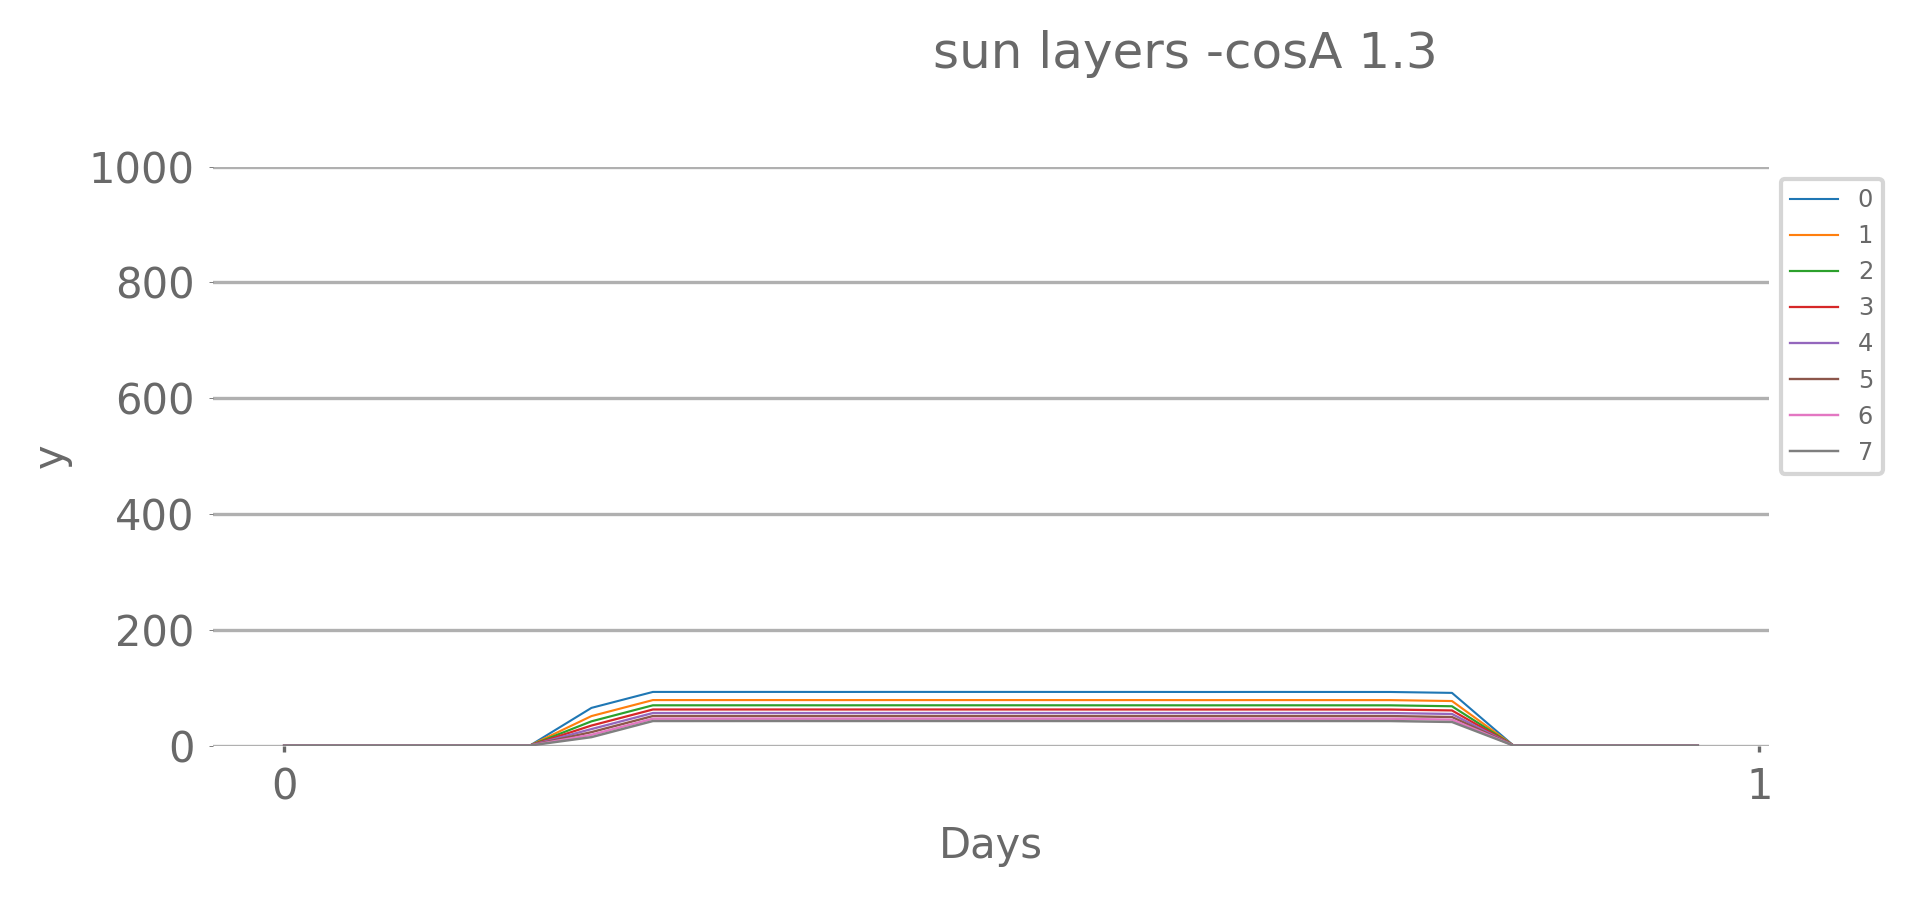

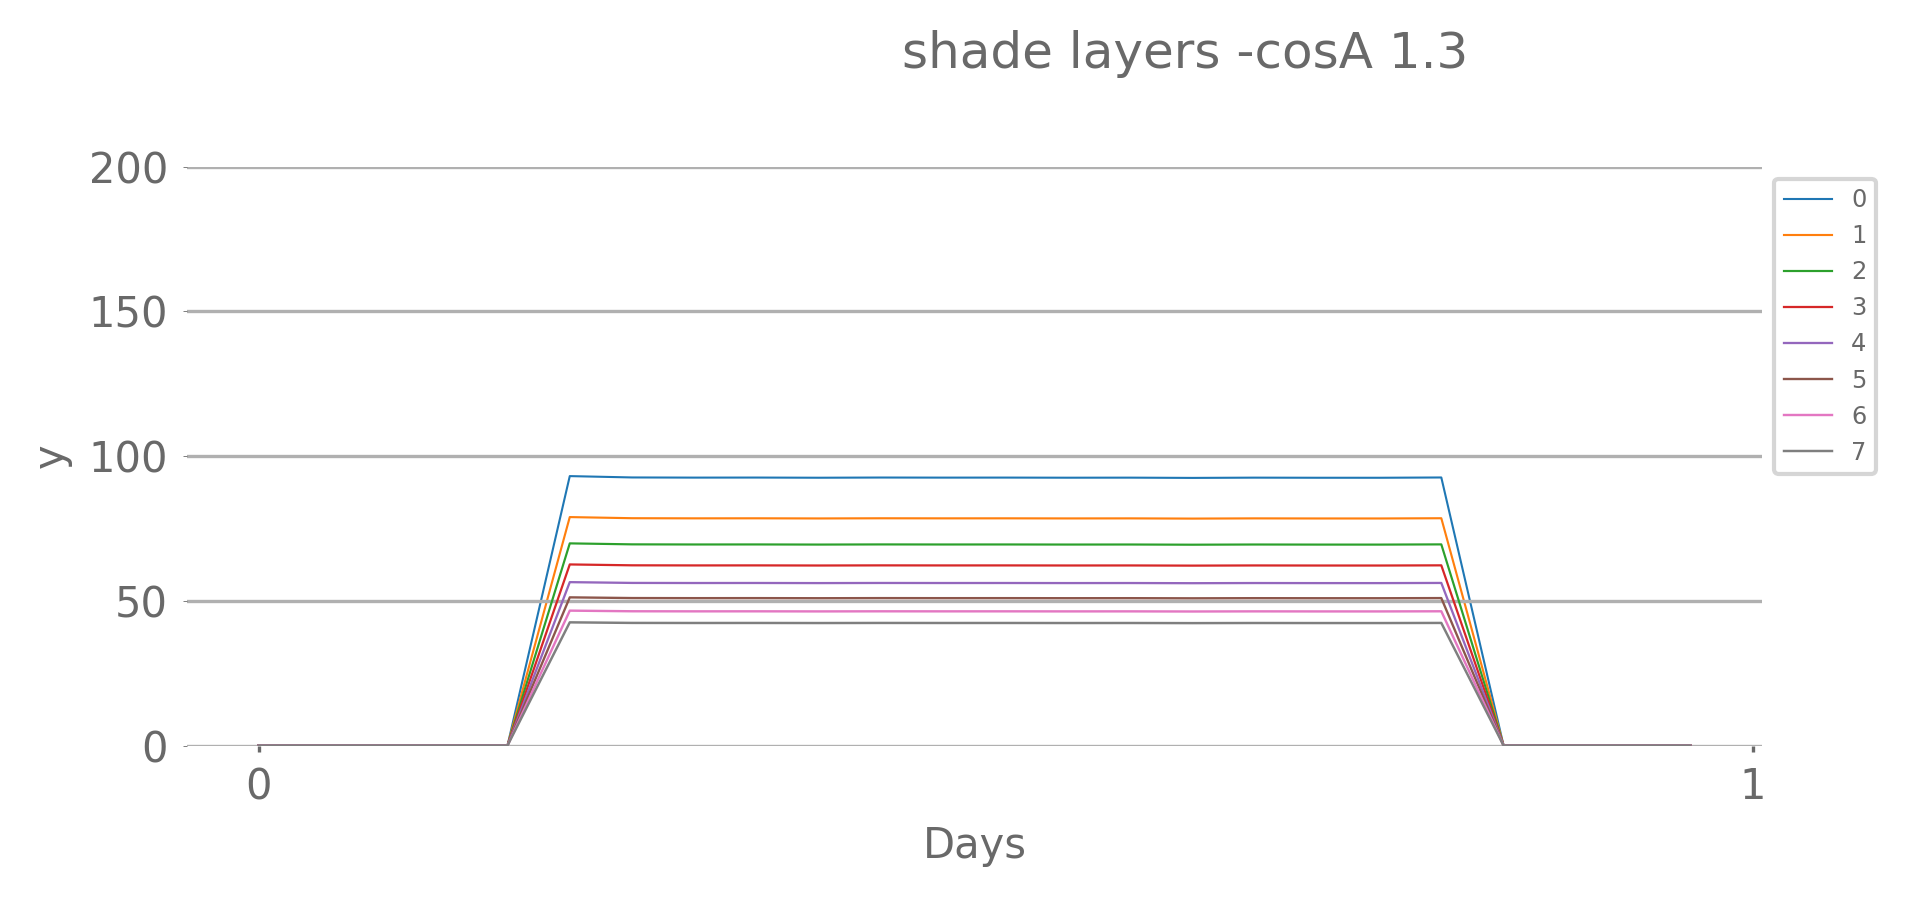

In [11]:
nL = 8
sun_vals, shade_vals = get_sun_shade_values_day(nL, cosA=1.3)
fig = multi_series_annual_graph(
    'sun layers -cosA 1.3',
    sun_vals,
    [i for i in range(nL)],
    None,
    label_x_days=30,
    average_step=1,
    top_y_lim=1000,
    end_day=1,
    figsize=(8, 3),
    dpi=300,
)
fig.show()
fig = multi_series_annual_graph(
    'shade layers -cosA 1.3',
    shade_vals,
    [i for i in range(nL)],
    None,
    label_x_days=30,
    average_step=1,
    top_y_lim=200,
    end_day=1,
    figsize=(8, 3),
    dpi=300,
)
fig.show()
